In [269]:
import unittest
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score

# The UNSW dataset
Published in "UNSW-NB15: A Comprehensive Data set for Network
Intrusion Detection systems" https://ieeexplore.ieee.org/document/7348942

This data set has a hybrid of the real modern normal and the contemporary synthesized attack activities of the network traffic. Existing and novel methods are utilised to generate the features of the UNSWNB15 data set.

The dataset contains 47 features per observation, which include:

- basic features (i.e., destination bits per second)
- flow features (source IP address, etc.), 
- content features (i.e., Mean of the flow packet size transmitted by the dst ), 
- time features (Source inter-packet arrival time),
- derived or generated features (i. e., No. of flows that has methods such as Get and Post in http service. )
- connection features (i.e., No. of connections that contain the same service (14) and source address (1) in 100 connections according to the last time (26). )


# Explore the dataset

In [270]:
# read data frame
df = pd.read_csv('UNSW_NB15_training-set.csv')



print("Shape of data frame ", df.shape[0])
print("Set of 10 records")
df.head(10)

df.describe(include = "all")

Shape of data frame  82332
Set of 10 records


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,82332.000000,82332.000000,82332,82332,82332,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332,82332.000000
unique,NaN,NaN,131,13,7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,43095,47153,39339,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37000,NaN
mean,41166.500000,1.006756,NaN,NaN,NaN,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,...,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,NaN,0.550600
std,23767.345519,4.710444,NaN,NaN,NaN,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,...,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,NaN,0.497436
min,1.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,20583.750000,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,NaN,0.000000
50%,41166.500000,0.014138,NaN,NaN,NaN,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,NaN,1.000000
75%,61749.250000,0.719360,NaN,NaN,NaN,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,...,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,NaN,1.000000


# Basic preprocessing

In [271]:
# drop the id and attack category, not used 
list_drop = ['id','attack_cat']
df.drop(list_drop, axis=1,inplace = True)


We need to be careful with the range anda values of the histogram:


array([[<Axes: title={'center': 'label'}>]], dtype=object)

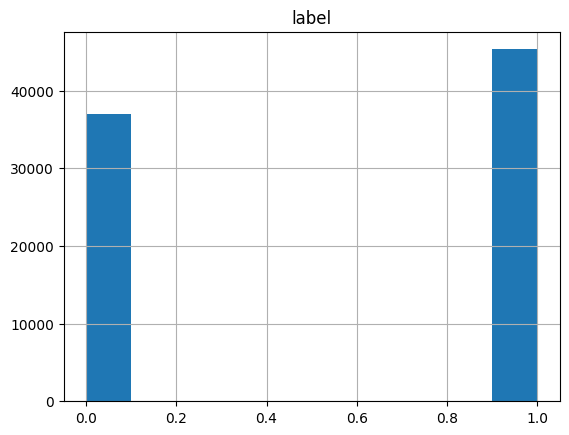

In [272]:
print("We need to be careful with the range anda values of the histogram:")
df.hist(column = "label")

In [273]:
# Get set of records with label 0 and 1
rows_with_label_0 = df[df['label'] == 0]
rows_with_label_1 = df[df['label'] == 1]

print(rows_with_label_0.shape)
print(rows_with_label_1.shape)

(37000, 43)
(45332, 43)


In [274]:
def plot_histogram(hist_values, bin_edges, title = "Histogram of Number of Rows with Label 0"):
    # Plot the histogram using matplotlib
    plt.hist(hist_values, bins=bin_edges, edgecolor='black')
    plt.title(title)
    plt.xlabel("Number of Rows")
    plt.ylabel("Frequency")
    plt.show()

# Encode the categorical features
The features state, protocol  and service (number 1, 2 and 3) are encoded  using one hot vector encoding, as those are categorical variables.



## First reduce the cardinality to reduce one hot encoded features dimensionality

In [275]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X.head()
feature_names = list(X.columns)
print("Original dimensionality before one hot encoding: ")
print("X  shape ", X.shape)

print("Number of different values per column using the dataframe ")
df.describe(include='all')

Original dimensionality before one hot encoding: 
X  shape  (82332, 42)
Number of different values per column using the dataframe 


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332,82332,82332,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
unique,NaN,131,13,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,43095,47153,39339,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.006756,NaN,NaN,NaN,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,4.710444,NaN,NaN,NaN,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,0.014138,NaN,NaN,NaN,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,0.719360,NaN,NaN,NaN,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000


The variable state has 7 different values, service 13 and protocol 131... perhaps there are too many values for each column. Therefore we can reduce the *cardinality* of the columns to use the 6 most frequent values. Otherwise, the dimensionality of the one hot vector variables will be too high!

In [276]:
#data frame with only the categorical variables
#service also defines the '-' category (to represent an unknown service) 
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,82332,82332,82332
unique,131,13,7
top,tcp,-,FIN
freq,43095,47153,39339


In [277]:
DEBUG = 1
for feature in df_cat.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_cat[feature].nunique()))
        print("Is the cardinality higher than 6? ", df_cat[feature].nunique()>6)
        print("Number of preserved records: ", sum(df[feature].isin(df[feature].value_counts().head().index)))
        print("New categories: (- takes the rest of categories)", df[feature].value_counts().head().index)
        print('----------------------------------------------------')
    
    if df_cat[feature].nunique()>6:
        #preserve only the records with values within the first 5 most frequent values (default by pandas)
        #replace with '-' if the value is not between the 5 most frequent
        df[feature] = np.where(df[feature].isin(df[feature].value_counts().head().index), df[feature], '-')

proto
nunique = 131
Is the cardinality higher than 6?  True
Number of preserved records:  77691
New categories: (- takes the rest of categories) Index(['tcp', 'udp', 'unas', 'arp', 'ospf'], dtype='object', name='proto')
----------------------------------------------------
service
nunique = 13
Is the cardinality higher than 6?  True
Number of preserved records:  80210
New categories: (- takes the rest of categories) Index(['-', 'dns', 'http', 'smtp', 'ftp'], dtype='object', name='service')
----------------------------------------------------
state
nunique = 7
Is the cardinality higher than 6?  True
Number of preserved records:  82330
New categories: (- takes the rest of categories) Index(['FIN', 'INT', 'CON', 'REQ', 'ACC'], dtype='object', name='state')
----------------------------------------------------


Let's see how the dataframe of categorical variables ended (much less unique values must appear): 

In [278]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,82332,82332,82332
unique,6,5,6
top,tcp,-,FIN
freq,43095,49275,39339


## Encode cardinality reduced columns
A total of 6 + 5 + 6 = 17 features are added, to the 42 - 3 = 39 features
We yield then 39 + 17 = 56 columns or fields

In [279]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
feature_names = list(X.columns)
print("Number of features before one hot encoding: ", len(feature_names))
#create the one hot encoder transformer and transform:
#columns 1, 2 and 3 are the ones to encode
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,3])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

print("Number of features after one hot encoding: ", X.shape)

Number of features before one hot encoding:  42
Number of features after one hot encoding:  (82332, 56)


# Prepare for model training

## Model metrics

In [280]:
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','time to train','time to predict','total time'])

We are going to test a logistic regression

In [281]:
# start = time.time()
# model = LogisticRegression(max_iter = 10000, tol=0.0001).fit(X_train, y_train)
# end_train = time.time()
# y_predictions_probs = model.predict_proba(X_test)
# y_predictions_labels = model.predict(X_test) # These are the predictions from the test data.
# print("y_predictions_probs \n ", y_predictions_probs, "y_predictions_labels \n ", y_predictions_labels)

# end_predict = time.time()

#  Test model

In [282]:
# accuracy = accuracy_score(y_test, y_predictions_labels)
# recall = recall_score(y_test, y_predictions_labels, average='weighted')
# precision = precision_score(y_test, y_predictions_labels, average='weighted')
# f1s = f1_score(y_test, y_predictions_labels, average='weighted')

# print("Accuracy: "+ "{:.2%}".format(accuracy))
# print("Recall: "+ "{:.2%}".format(recall))
# print("Precision: "+ "{:.2%}".format(precision))
# print("F1-Score: "+ "{:.2%}".format(f1s))
# print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
# print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
# print("total: "+"{:.2f}".format(end_predict-start)+" s")
# model_performance.loc['Logistic'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

# Least Squares

In [301]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def estimate_optimum_LS(t, M):
    M_pinv = torch.linalg.pinv(M)
    w_opt = M_pinv.mm(t)
    return w_opt

def activation_function(y):
    y[y > 0.5] = 1
    y[y <= 0.5 ] = 0
    t_estimated = y
    return t_estimated

def forward(M, w):
    """
    Get model output, with NO FORS
    param M: dataset
    return t_estimated, with 1 or 0
    """
    y = M.mm(w)
    return activation_function(y)

def evaluate_error(t, t_estimated):
    """
    Evaluate model error using the euclidian distance
    param t, real targets
    param t_estimated, estimated targets by the model
    """
    error = torch.norm(t - t_estimated, 1) / t.shape[0]

    return error
  
def estimate_optimum_w_GD(TargetsAll, SamplesAll, alpha, epochs):
    """ Estimate the optimum W with NO FORS
    param TargetsAll, NumSamples x 1 matrix with target values (1 or -1)
    param SamplesAll, NumSamples x NumDimensions 
    return wOpt, array with optimum weights
    """
    SamplesAlltrans = SamplesAll.t()
    error_per_epoch = np.zeros(epochs)
    #random initial search point
    wT = torch.rand((56, 1), device = device )
    #wT = wT.unsqueeze(0) # add 2nd dim
    TargetsAll = TargetsAll.unsqueeze(0)
    TargetsAll = TargetsAll.t()
    print(TargetsAll) # add 2nd dim
    print("SamplesAll.shape[0] \n", SamplesAll.shape[0])

    #type matching TODO: fix this positioning
    datatype = torch.double
    SamplesAll = SamplesAll.type(datatype)
    SamplesAlltrans = SamplesAlltrans.type(datatype)
    wT = wT.type(datatype)
    TargetsAll = TargetsAll.type(datatype)

    for epoch in range(0, epochs):
        #Calculate gradient error      
        #errorGradient = (1 / SamplesAll.shape[0]) * SamplesAlltrans.mm(SamplesAll).mm(wT) - SamplesAlltrans.mm(TargetsAll)
        errorGradient = (1 / SamplesAll.shape[0]) * SamplesAlltrans.mm(SamplesAll).mm(wT) - SamplesAlltrans.mm(TargetsAll)
        #update weights
        wT -= alpha * errorGradient  
        #estimate error for the current epoch
        EstimatedTargetsAll = forward(SamplesAll, wT)
        error = evaluate_error(TargetsAll, EstimatedTargetsAll)
        #print("Epoch: ", epoch, " error: ", error)
        #saves the error
        error_per_epoch[epoch] = error
    return (wT, error_per_epoch)


def data_split(X, y, random_state = 5, test_size = 0.2):
    # Se particionan los datos con un 20% de prueba y 80% de datos de entrenamiento test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = test_size, 
                                                        random_state = random_state,
                                                        stratify = y)


    # for our least squares model only
    X_train = torch.tensor(X_train)
    X_test = torch.tensor(X_test)
    y_train = y_train.values.reshape(-1, 1)
    y_train = torch.tensor(y_train, dtype=torch.float64)
    y_test = y_test.values.reshape(-1, 1)
    y_test = torch.tensor(y_test, dtype=torch.float64)

    return (X_train, X_test, y_train, y_test)
    

# Test Least Squares

In [290]:
alpha = 0.0025
epochs = 5000


# TODO: plotear los f1 scores y los accuracies

runs = 30
f1_scores = []
accuracies = []
for i in range(runs):
    X_train, X_test, y_train, y_test = data_split(X, y, i)
    w_opt = estimate_optimum_LS(y_train, X_train)
    estimated_y = forward(X_test, w_opt)
    estimated_f1_score = f1_score(y_test, estimated_y)
    estimated_accuracy = accuracy_score(y_test, estimated_y)
    f1_scores.append(torch.tensor(estimated_f1_score))
    accuracies.append(torch.tensor(estimated_accuracy))
    print(f"{i+1} & {'{:.2%}'.format(estimated_accuracy).replace('%', '\\%')}    & {'{:.2%}'.format(estimated_f1_score).replace('%', '\\%')}    \\\\ \\hline")


var_f1_scores = torch.var(torch.tensor(f1_scores))
mean_f1_scores = torch.mean(torch.tensor(f1_scores))

var_accuracies = torch.var(torch.tensor(accuracies))
mean_accuracies = torch.mean(torch.tensor(accuracies))

print("Varianza F1 Score: ", '{:.2%}'.format(var_f1_scores))
print("Media F1 Score: ", '{:.2%}'.format(mean_f1_scores))
print("Varianza Tasa de Aciertos: ", '{:.2%}'.format(var_accuracies))
print("Media Tasa de Aciertos: ", '{:.2%}'.format(mean_accuracies))



1 & 89.04\%    & 90.13\%    \\ \hline
2 & 88.89\%    & 89.93\%    \\ \hline
3 & 89.20\%    & 90.25\%    \\ \hline
4 & 89.21\%    & 90.26\%    \\ \hline
5 & 88.92\%    & 90.01\%    \\ \hline
6 & 88.47\%    & 89.61\%    \\ \hline
7 & 88.81\%    & 89.92\%    \\ \hline
8 & 88.95\%    & 89.96\%    \\ \hline
9 & 88.11\%    & 89.16\%    \\ \hline
10 & 88.98\%    & 90.01\%    \\ \hline
11 & 89.46\%    & 90.55\%    \\ \hline
12 & 89.19\%    & 90.20\%    \\ \hline
13 & 88.24\%    & 89.29\%    \\ \hline
14 & 89.00\%    & 90.05\%    \\ \hline
15 & 89.20\%    & 90.25\%    \\ \hline
16 & 89.17\%    & 90.20\%    \\ \hline
17 & 88.94\%    & 89.96\%    \\ \hline
18 & 88.63\%    & 89.68\%    \\ \hline
19 & 88.61\%    & 89.60\%    \\ \hline
20 & 89.04\%    & 90.11\%    \\ \hline
21 & 88.44\%    & 89.53\%    \\ \hline
22 & 88.44\%    & 89.56\%    \\ \hline
23 & 88.50\%    & 89.63\%    \\ \hline
24 & 89.04\%    & 90.09\%    \\ \hline
25 & 88.61\%    & 89.67\%    \\ \hline
26 & 89.23\%    & 90.26\%    \\ \h

# Ensemble

In [319]:
def train_ensemble(x, x_train, y_train,  N):
   kf_partitioner = KFold(n_splits = N, shuffle=True)
   kf_partitions = kf_partitioner.split(x_train, y_train)
   predictions = []
   for i, (_, train_partition) in enumerate(kf_partitions):
      X_train_n = X_train[train_partition]
      y_train_n = y_train[train_partition]
      w_opt_n = estimate_optimum_LS(y_train_n, X_train_n)
      # Prediction with no activation function
      prediction_n =  x.mm(w_opt_n)
      predictions.append(prediction_n)

   predictions = torch.stack(predictions)
   return predictions

def run_ensemble_uq(ensemble):
   uncertainty = torch.var(ensemble, dim=0)
   min_val = uncertainty.min()
   max_val = uncertainty.max()
   # Normalize the tensor
   normalized_uncertainties = (uncertainty - min_val) / (max_val - min_val)
   return normalized_uncertainties

# TODO: verify meaning of parameteres (x, model, N = 10)
def quantify_uncertainty_ensemble(x, x_train, y_train, N = 10):
   ensemble = train_ensemble(x, x_train, y_train,  N)
   return run_ensemble_uq(ensemble), torch.mean(ensemble, dim=0)

# s, pred = quantify_uncertainty_ensemble(X_test, X_train, y_train, 10)

# total_s = []
# total_a = []
# for i in range(30):
#    s, pred = quantify_uncertainty_ensemble(X_test, X_train, y_train, 100)
#    s_mean = torch.mean(s)
#    a_mean = torch.mean(torch.tensor(accuracy_score(y_test, activation_function(pred))))
#    total_s.append(s_mean)
#    total_a.append(a_mean)

# plt.scatter(total_s, total_a)
# plt.show()

# ECE calculation

In [158]:
# uncertainty_scores, _ = torch.max(torch.tensor(y_predictions_probs), dim = 1)
# print("uncertainty_scores \n ", uncertainty_scores)
# TODO: verificar si deberiamos usar estos valores, o el promedio de estas formulas, o de hecho decision_function(X)



In [298]:
def calculate_expected_calibration_error(X_test, y_test, uncertainties, pred, bins=10):
    #TODO: add selector for ordering param or not
    kf_partitioner = KFold(n_splits = bins)
    kf_partitions = kf_partitioner.split(X_test, y_test)
    X_test_total = X_test.shape[0]
    bin_sum = 0.0
    for i, (_, bin_partitions) in enumerate(kf_partitions):
        if len(bin_partitions) == 0:
            continue
        X_bin_test = X_test[bin_partitions]
        y_bin_test = y_test[bin_partitions]
        X_bin_test_total = X_bin_test.shape[0]
        uncertainties_bin = uncertainties[bin_partitions]
        pred_bin = pred[bin_partitions]
        accuracies_bin = torch.tensor(accuracy_score(y_bin_test, activation_function(pred_bin)))
        bin_sum += (X_bin_test_total/X_test_total) * torch.abs(accuracies_bin - torch.mean(uncertainties_bin))
    return bin_sum

s, pred = quantify_uncertainty_ensemble(X_test, X_train, y_train, 10)
calculate_expected_calibration_error(X_test, y_test, s, pred, 10)

tensor(0.8867, dtype=torch.float64)

# Prueba ECE

N 10


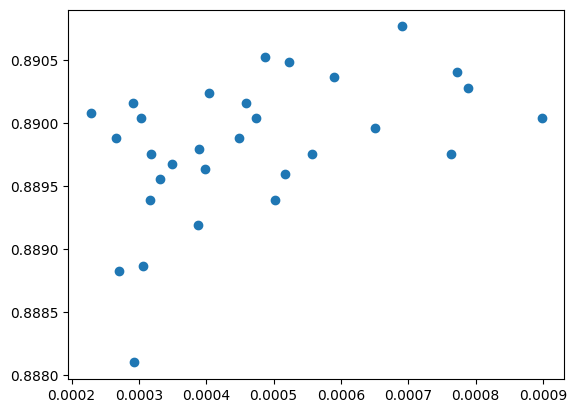

Media ECE: tensor(0.8894, dtype=torch.float64)
Std Dev. ECE: tensor(0.0005, dtype=torch.float64)
N 100


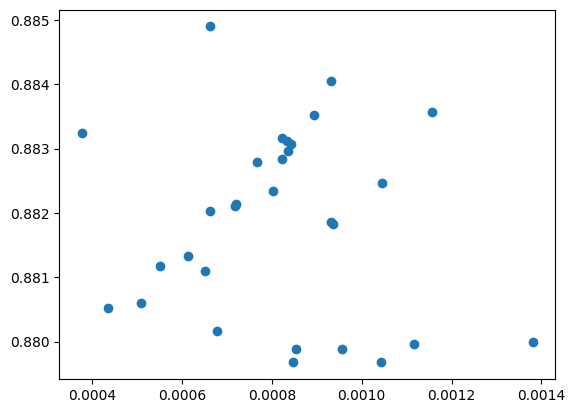

Media ECE: tensor(0.8811, dtype=torch.float64)
Std Dev. ECE: tensor(0.0015, dtype=torch.float64)
N 1000


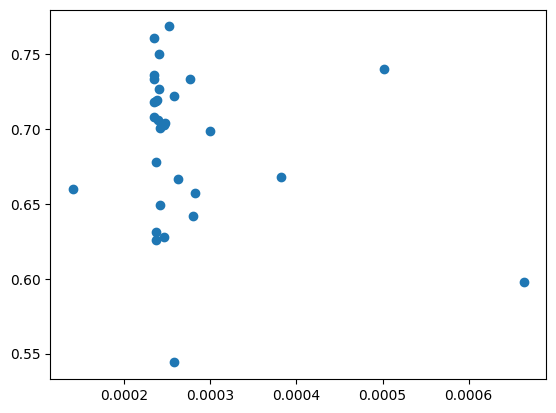

Media ECE: tensor(0.6895, dtype=torch.float64)
Std Dev. ECE: tensor(0.0517, dtype=torch.float64)


In [338]:
Ns = [10, 100, 1000]
executions = 30


# Por cada N
for N in Ns:
    # Por una cantidad dada de ejecuciones
    print("N", N)
    eces = []
    uncertainties = []
    accuracies = []
    predictions = []
    for execution in range(executions):
        # Se particionan los datos en 30% test y 70% train
        X_train, X_test, y_train, y_test = data_split(X, y, i, 0.3)
        # Incertidumbres
        s, pred = quantify_uncertainty_ensemble(X_test, X_train, y_train, N)

        # ECE
        ece = calculate_expected_calibration_error(X_test, y_test, s, pred, 10)
        eces.append(ece)
        
        predictions.append(pred)

        uncertainties_mean = torch.mean(s)
        accuracies_mean = torch.mean(torch.tensor(accuracy_score(y_test, activation_function(pred))))
        uncertainties.append(uncertainties_mean)
        accuracies.append(accuracies_mean)

    
    eces = torch.tensor(eces)
    mean_ece = torch.mean(eces)
    std_ece = torch.std(eces)

    uncertainties = torch.tensor(uncertainties)


    # plot_uncertainty_vs_accuracy(uncertainties, predictions, y_test)
    plt.scatter(uncertainties, accuracies)
    plt.show()

    print("Media ECE:", mean_ece)
    print("Std Dev. ECE:", std_ece)

In [336]:
import matplotlib.pyplot as plt

def plot_uncertainty_vs_accuracy(uncertainties, y_preds, y_true, num_bins=10):
    """  Plots a histogram showing the distribution of accuracy across different uncertainty bins.
    Args:
    uncertainties (list): List of uncertainty values for each observation.      y_preds (list): List of predicted labels.
    y_true (list): List of true labels.      num_bins (int, optional): Number of bins for the histogram. Defaults to 10.
    """
    # Calculate accuracy for each data point
    accuracy = np.array([(y_pred == y_true) for y_pred, y_true in zip(y_preds, y_true)])
    # Create bins based on uncertainties
    bins = plt.hist(uncertainties, bins=num_bins, edgecolor='black')[1]
    # Calculate average accuracy within each bin
    bin_accuracies = []
    for i in range(len(bins) - 1):    # Select data points within the current bin range
        bin_indices = (uncertainties >= bins[i]) & (uncertainties < bins[i + 1])
        bin_accuracy = np.mean(accuracy[bin_indices])
        bin_accuracies.append(bin_accuracy)
    # Plot the histogram and accuracy line 
    plt.bar(bins[:-1], bin_accuracies, width=bins[1] - bins[0], alpha=0.7, label='Accuracy')
    plt.xlabel('Uncertainty')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy Distribution across Uncertainty Bins')
    plt.legend()
    plt.grid(True)
    plt.show()
    # Example usage:# Assuming you have uncertainties, y_preds, and y_true


## ECE calculation Unit test

In [161]:
class ECEUnitTest(unittest.TestCase):

    def test_eceWithHomogeneousDfValues(self):
      x_test_ut = torch.ones(2, 56).to(torch.double)
      y_test_ut = torch.ones(2, 1).to(torch.double)
      x_train_ut = torch.ones(2, 56).to(torch.double)
      y_train_ut = torch.ones(2, 1).to(torch.double)
      s, pred = quantify_uncertainty_ensemble(x_test_ut, x_train_ut, y_train_ut, 2)
      ece = calculate_expected_calibration_error(x_test_ut, y_test_ut, s, pred, 2)
      self.assertAlmostEqual(ece.item(), 0.0, delta=0.0001)

    def test_eceWithNonHomogeneousDfValues(self):
      x_test_ut = X_test
      y_test_ut = y_test
      x_train_ut = X_train
      y_train_ut = y_train
      s, pred = quantify_uncertainty_ensemble(x_test_ut, x_train_ut, y_train_ut, 2)
      ece = calculate_expected_calibration_error(x_test_ut, y_test_ut, s, pred, 2)
      self.assertAlmostEqual(ece.item(), 0.8884, delta=0.001)

unittest.main(argv=[''], verbosity=2, exit=False)

test_eceWithHomogeneousDfValues (__main__.ECEUnitTest) ... ok
test_eceWithNonHomogeneousDfValues (__main__.ECEUnitTest) ... 

ok

----------------------------------------------------------------------
Ran 2 tests in 0.376s

OK


# TODO: Usar modelo de Least Squares (tenemos uno hecho en clase)
ademas correr ese 30 veces
## Ensemble
recordatorio: Cada modelo se entrena con un split de X_train, pero todos usan el mismo test
# TODOS: 
N modelos, los vamos a entrenar con diferentes particiones del dataset
De cada uno hacer un test y obtener el y_predictions_probs
# TODO: Averiguar cómo obtener la uncertainty a partir de esto (ver clases)
